In [1]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from tqdm.auto import tqdm

from src.configspace import (
    COX_PH_CONFIGSPACE,
    RANDOM_SURVIVAL_FOREST_CONFIGSPACE,
    XGB_AFT_CONFIGSPACE,
    CoxPHSurvivalAnalysis,
    RandomSurvivalForest,
    XGBRegressorAFT,
)
from src.evaluation import evaluate_model_with_cross_validation
from src.hyperparameter_optimization import optimize_hyperparameters
from src.split import get_n_splits
from src.wrapper import ScikitLearnWrapper
from src.survival_function_wrapper import SurvivalFunctionWrapper
from src.xgb_wrapper import XGBwrapper

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*algorithm did not converge.*")

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.2
plt.rcParams["grid.color"] = "#cccccc"
plt.rcParams["axes.xmargin"] = 0

PHASE1_DIR = Path(".")
PROCESSED_DIR = PHASE1_DIR / "processed"

In [2]:
evaluations_df = pd.read_parquet(PROCESSED_DIR / "evaluations.parquet")
solvers_df = pd.read_parquet(PROCESSED_DIR / "solvers.parquet")
instances_df = pd.read_parquet(PROCESSED_DIR / "instances.parquet")

df = pd.merge(evaluations_df, solvers_df, left_on="solver_id", right_on="id").drop(columns=["id"])
df = pd.merge(df, instances_df, left_on="instance_id", right_on="id").drop(columns=["id"])
df

,solver_id,instance_id,generator,cost,ASCENT_CANDIDATES,BACKBONE_TRIALS,BACKTRACKING,CANDIDATE_SET_TYPE,EXTRA_CANDIDATES,EXTRA_CANDIDATE_SET_TYPE,...,mst_dists_span,mst_dists_coef_of_var,mst_dists_sum,nnds_min,nnds_median,nnds_mean,nnds_max,nnds_sd,nnds_span,nnds_coef_of_var
0,1251473931473582278,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,4.74,0.95,1.0,0.0,0.0,0.2,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
1,2289112522627003788,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,0.02,0.15,0.0,1.0,1.0,0.4,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
2,960932965817811220,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,3.72,0.20,0.0,1.0,2.0,0.9,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
3,39012066323493184,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,1.52,0.60,1.0,1.0,2.0,0.7,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
4,494182449327999052,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,84.44,0.90,1.0,1.0,3.0,0.3,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1286196444435323941,TSP/TRAIN/grid/019.tsp,grid,208.32,0.45,0.0,0.0,0.0,0.2,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99996,1435531534300921454,TSP/TRAIN/grid/019.tsp,grid,300.00,0.20,1.0,0.0,3.0,0.6,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99997,27607668447685341,TSP/TRAIN/grid/019.tsp,grid,3.21,0.95,1.0,1.0,3.0,0.9,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99998,2245205590089179674,TSP/TRAIN/grid/019.tsp,grid,17.23,0.65,0.0,0.0,1.0,0.5,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201


In [3]:
CONST_CUT_OFF = 1

In [4]:
N_TRIALS = 5
N = 3
INSTANCE_NUMBER = 10
SOLVER_NUMBER = 90
RANDOM_STATE = 0

SPLITS = get_n_splits(
    df=df,
    n=N,
    instance_number=INSTANCE_NUMBER,
    solver_number=SOLVER_NUMBER,
    random_state=RANDOM_STATE,
)

### CoxPHSurvivalAnalysis

In [5]:
coxph_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=CoxPHSurvivalAnalysis,
    wrapper_cls=SurvivalFunctionWrapper,
    configspace=COX_PH_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
    const_cut_off=CONST_CUT_OFF,
)
coxph_incumbent

[INFO][abstract_initial_design.py:95] Reducing the number of initial configurations from 50 to 1 (max_ratio == 0.25).
[INFO][abstract_initial_design.py:147] Using 1 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 2f56c8 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:595] Added config 60e44e and rejected config 2f56c8 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:328] Configuration budget is exhausted:
[INFO][smbo.py:329] --- Remaining wallclock time: inf
[INFO][smbo.py:330] --- Remaining cpu time: inf
[INFO][smbo.py:331] --- Remaining trials: 0


{'alpha': 18.1103247457952,
 'risk_function': 'par10',
 'ties': 'breslow',
 'model_cls': sksurv.linear_model.coxph.CoxPHSurvivalAnalysis}

### RandomSurvivalForest

In [6]:
rsf_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=RandomSurvivalForest,
    wrapper_cls=SurvivalFunctionWrapper,
    configspace=RANDOM_SURVIVAL_FOREST_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
    const_cut_off=CONST_CUT_OFF,
)
rsf_incumbent

[INFO][abstract_initial_design.py:95] Reducing the number of initial configurations from 90 to 1 (max_ratio == 0.25).
[INFO][abstract_initial_design.py:147] Using 1 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 20fae2 as new incumbent because there are no incumbents yet.
[INFO][smbo.py:328] Configuration budget is exhausted:
[INFO][smbo.py:329] --- Remaining wallclock time: inf
[INFO][smbo.py:330] --- Remaining cpu time: inf
[INFO][smbo.py:331] --- Remaining trials: 0


{'max_depth': 10,
 'max_features': 0.6205646954477,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_jobs': -1,
 'random_state': 0,
 'risk_function': 'par10',
 'model_cls': sksurv.ensemble.forest.RandomSurvivalForest}

### XGBRegressorAFT

In [7]:
xgb_aft_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=XGBRegressorAFT,
    wrapper_cls=XGBwrapper,
    configspace=XGB_AFT_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
    const_cut_off=CONST_CUT_OFF,
)
xgb_aft_incumbent

[INFO][abstract_initial_design.py:95] Reducing the number of initial configurations from 140 to 1 (max_ratio == 0.25).
[INFO][abstract_initial_design.py:147] Using 1 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 1f402b as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:595] Added config fd3eab and rejected config 1f402b as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:328] Configuration budget is exhausted:
[INFO][smbo.py:329] --- Remaining wallclock time: inf
[INFO][smbo.py:330] --- Remaining cpu time: inf
[INFO][smbo.py:331] --- Remaining trials: 0


{'aft_loss_distribution': 'extreme',
 'colsample_bytree': 0.5205963782443,
 'eval_metric': 'aft-nloglik',
 'gamma': 2.2060993338149,
 'learning_rate': 0.057402198671,
 'max_depth': 8,
 'min_child_weight': 3,
 'num_boost_round': 399,
 'objective': 'survival:aft',
 'reg_alpha': 0.0279989033139,
 'reg_lambda': 0.0436290320476,
 'seed': 0,
 'subsample': 0.7674455327117,
 'model_cls': src.configspace.XGBRegressorAFT}

## Comparison

In [8]:
model_info_list = [
    {
        "wrapper": SurvivalFunctionWrapper(**coxph_incumbent),
        "name": "Cox PH"
    },
    {
        "wrapper": SurvivalFunctionWrapper(**rsf_incumbent),
        "name": "Random Survival Forest"
    },
    {
        "wrapper": XGBwrapper(**xgb_aft_incumbent),
        "name": "XGBoost AFT"
    },
]
 
# random_state_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
random_state_list = [1]
solver_number_list = [5, 10, 15, 20, 30, 50, 70, 100, 150, 200, 300, 500]
total_iterations = len(random_state_list) * len(solver_number_list) * len(model_info_list)
pbar = tqdm(total=total_iterations, desc="Evaluating models")

records = []

for random_state in random_state_list:
    for solver_number in solver_number_list:
        pbar.set_description(f"RS={random_state}, Solvers={solver_number}")
        splits = get_n_splits(
            df,
            n=5,
            instance_number=10,
            solver_number=solver_number,
            random_state=random_state,
        )
        for model_info in model_info_list:
            pbar.set_postfix(model=model_info["name"])

            result = evaluate_model_with_cross_validation(
                df,
                wrapper=model_info["wrapper"],
                splits=splits,
                const_cut_off=CONST_CUT_OFF,
                random_state=random_state,
            )
            result["random_state"] = random_state
            result["solver_number"] = solver_number
            result["name"] = model_info["name"]
            records.append(result)
            pbar.update(1)

result_df = pd.DataFrame(records)

Evaluating models:   0%|          | 0/36 [00:00<?, ?it/s]

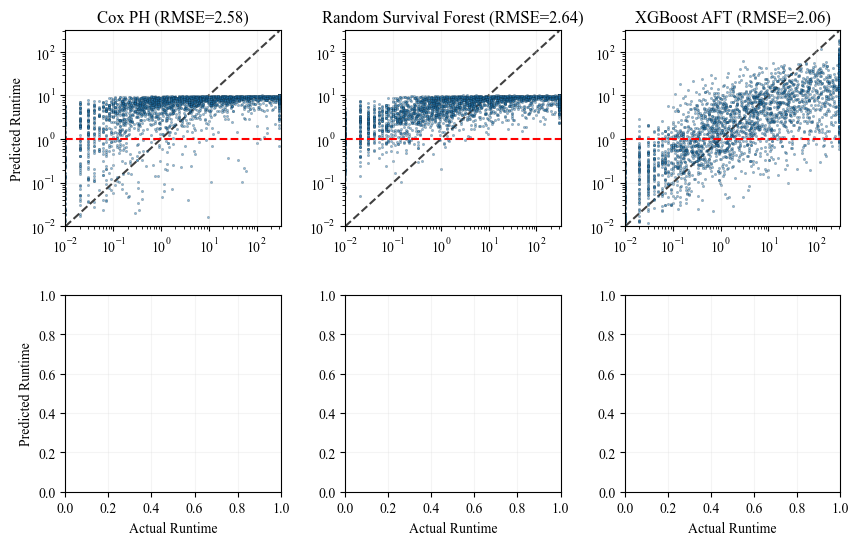

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
axs = axs.flatten()

plot_df = result_df.loc[(result_df["random_state"] == 1) & (result_df["solver_number"] == 300)].reset_index(drop=True)

for i, result in plot_df.iterrows():
    ax = axs[i]

    sc = ax.scatter(
        result["y_test_not_censored"],
        result["y_pred"],
        alpha=0.5,
        edgecolors="k",
        lw=0.2,
        s=3,
    )
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.set_xlim(0.01, 320)
    ax.set_ylim(0.01, 320)
    ax.plot([0.01, 300], [0.01, 300], "k--", alpha=0.75, zorder=0)
    ax.set_title(f'{result["name"]} (RMSE={result["rmse"]:.2f})')
    ax.axhline(y=1, color='red', linestyle='--')

axs[0].set_ylabel("Predicted Runtime")
axs[3].set_ylabel("Predicted Runtime")
axs[3].set_xlabel("Actual Runtime")
axs[4].set_xlabel("Actual Runtime")
axs[5].set_xlabel("Actual Runtime")
plt.subplots_adjust(wspace=0.3, hspace=0.35)
# plt.savefig("runtime_predictions.png", dpi=300, bbox_inches="tight")
plt.show()

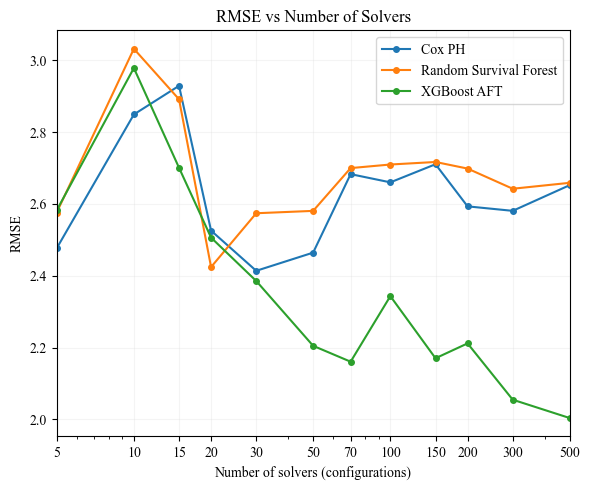

In [10]:
fig, ax = plt.subplots(figsize=(6, 5))

plot_df = result_df.groupby(["name", "solver_number"], sort=False)["rmse"].mean().reset_index()

for name, group in plot_df.groupby("name", sort=False):
    plt.plot(
        group['solver_number'], 
        group['rmse'], 
        'o-', 
        label=name,
        linewidth=1.5,
         markersize=4
    )

plt.xscale('log')
plt.xlabel('Number of solvers (configurations)')
plt.ylabel('RMSE')
plt.legend(loc='best', frameon=True)
plt.xticks(plot_df['solver_number'].unique(), plot_df['solver_number'].unique())
plt.title('RMSE vs Number of Solvers')
plt.tight_layout()
# plt.savefig("rmse_vs_solver_number.png", dpi=300, bbox_inches="tight")
plt.show()

In [11]:
result_df.pivot_table(
    columns="name",
    index="solver_number",
    values="rmse",
)

name,Cox PH,Random Survival Forest,XGBoost AFT
solver_number,,,
5,2.476271,2.575738,2.582027
10,2.849093,3.031891,2.978291
15,2.928849,2.891391,2.700723
20,2.525672,2.424348,2.506267
30,2.413845,2.574100,2.385514
50,2.464478,2.580666,2.205052
70,2.682992,2.699780,2.160800
100,2.660078,2.709744,2.343335
150,2.710504,2.716795,2.170412
